# 1. Data Description and Data Transformation
We investigate customer segmentation problem by clustering on ‘Bike Sale’ dataset which including 3 files related to customers, products and orders information. First, we need to merge 3 files together based on their common Customer ID and Product ID. We are interested in deciding the preference of bikes that each customer ‘bike shop’ have. Therefore, we need to process our data into a format with row containing bike shop name and features are the bike model. The hypothesis for our customer trends is that bike shops purchase certain bike models based on features such as bike categories (Mountain or Road) and price tier (high or low). Although we will use bike model to cluster on, the bike model features such as price, category will be used for assessing the preference of the customer clusters.

First, the unit of measure to cluster on the quantity purchased because the total purchases value would be skewed by the bike price. Then we group the data by bike model and model features which are price, category, frame and summarize by quantity purchased. Next, we manipulate price into some categorical variables representing high or low. We assume that the bike is high-end if its price is above the median which is $3500 and the bike is low-end otherwise. Last, we need to scale the bike model quantities purchased by customer so the k-means algorithm weights the purchases of each customer evenly. The final data format should have the customers as rows and models as columns. Our record contains 30 bike shops with 98 distinct models, so our final data has 30 rows and 98 features. From our hypothesis, we expect there to be at least 4 because customer preference is expected to vary by price (high/low) and category (mountain vs bike). There might be other groupings as well, but clustering more than 8 segments may be overfitting the segments. 

In [27]:
import pandas as pd
import numpy as np 
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.mixture import GaussianMixture
from sklearn.random_projection import GaussianRandomProjection,SparseRandomProjection
import matplotlib.pyplot as plt
import random
import pylab as pl
import copy
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture
from ggplot import *
orders = pd.read_csv('orders.csv')
customers = pd.read_csv('bikeshops.csv')
products = pd.read_csv('bikes.csv')

customers.rename(columns={'bikeshop.id': 'customer.id'}, inplace=True)
products.rename(columns={'bike.id': 'product.id'}, inplace = True)

orders_extend = pd.merge(orders, customers, on='customer.id', how='left')
orders_extend = pd.merge(orders_extend, products, on = 'product.id', how='left')

def calculate(s):
    a = s['price'] * s['quantity'] # Simple calc for example
    return pd.Series({'price_extended': a})

orders_extend = orders_extend.merge(orders_extend.apply(calculate, axis=1), left_index=True, right_index=True)
orders_extend = orders_extend[['order.date','order.id', 'order.line', 'bikeshop.name', 
'model', 'quantity', 'price', 'price_extended', 'category1', 'category2', 'frame']]
orders_extend.sort_values(['order.id', 'order.line'])

def get_stats(group):
	return {'total_quantity': group.sum()}

customerTrends = orders_extend.groupby(['bikeshop.name','model','category1','category2','frame','price'])

df= customerTrends['quantity'].apply(get_stats).unstack()
df.reset_index(level=['bikeshop.name','model','category1','category2','frame','price'],inplace=True)
df = pd.pivot_table(df, columns=['bikeshop.name'],index=['model','category1','category2','frame','price'], values = 'total_quantity', aggfunc=np.sum)
df.fillna(0, inplace=True)
df1 = df.copy()
df.reset_index(level=['model','category1','category2','frame','price'],inplace=True)
# print(df1.head())

df1.loc['Total']= df1.sum(numeric_only=True)
df1 = df1/df1.ix['Total']
df1.reset_index(level=None, inplace=True)

df1['model'] = df['model']
df1['category1'] = df['category1']
df1['category2'] = df['category2']
df1['frame'] = df['frame']
df1['price'] = df['price']
del df1['index']
print(df1)
# row: 30 customer, column: 98 model
df2 = df1.iloc[:-1,:30].transpose()
df2.columns = df['model']
data = np.array(df2)
column = np.array(df2.columns)
ind = np.array(df2.index).tolist()
# ind = list(range(len(customer_name)))
# print(ind)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


bikeshop.name  Albuquerque Cycles  Ann Arbor Speed  Austin Cruisers  \
0                        0.017483         0.006645         0.008130   
1                        0.006993         0.009967         0.004065   
2                        0.010490         0.014950         0.008130   
3                        0.010490         0.009967         0.008130   
4                        0.003497         0.003322         0.000000   
5                        0.013986         0.026578         0.020325   
6                        0.006993         0.014950         0.020325   
7                        0.000000         0.016611         0.004065   
8                        0.013986         0.014950         0.024390   
9                        0.048951         0.008306         0.008130   
10                       0.013986         0.026578         0.016260   
11                       0.013986         0.013289         0.032520   
12                       0.027972         0.023256         0.012195   
13    

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


# 2. Unsupervised Algorithms for Clustering
## 2.1) K-means

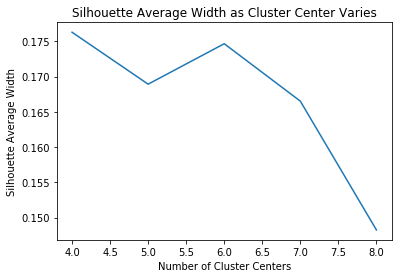

In [30]:
silhouse = []
km = []
minClust, maxClust= 4,9
n = list(range(minClust,maxClust))
for center in list(range(minClust, maxClust)): 
	i = center - (minClust - 1)
	random.seed(11)
	kmeans = KMeans(n_clusters=center).fit(data)
	labels = kmeans.labels_
	km.append(labels)
	silhouse.append(metrics.silhouette_score(data, labels))

#ggplot(frame(n, silhouse), aes(x,y))
plt.plot(n , silhouse)
plt.title("Silhouette Average Width as Cluster Center Varies")
plt.xlabel("Number of Cluster Centers")
plt.ylabel("Silhouette Average Width")
plt.show()

We use Silhouette widths to validate the best cluster groups. The best cluster is the one with the largest silhouette average widths, which turns out to be 5 clusters.  
After k-means clustering, we have 5 groups with a list of bike shop names in each group. To determine the general customer preference, we inspect factors related to the list of models in each group. This is not to track back to the models bought by each store and the model’s features. However, we assume that the cluster’s center can sufficiently describe the characteristics of each group. We investigate the top ten models most bought by the bike shops that are the cluster’s centers. Then we check the features such as category1, frame, and price of these models.  
![alt text](https://user-images.githubusercontent.com/30711638/35762978-fb6575c2-086f-11e8-9ae9-22ae8c3754b8.png)
![alt text](https://user-images.githubusercontent.com/30711638/35763004-8083966c-0870-11e8-990e-bb642451cea2.png)
The Table 2 and table 3 show top 10 bike models in descending order of cluster 1 and 2. Table 1 shows that the majority of models belongs to cluster 1 are low-end price and road types. Cluster 2 prefers models with expensive price, mountain types and carbon frame. Cluster 3 prefer low-end price with a mix of mountain and road types. Cluster 4 tends to prefer road bikes that are high-end. Cluster 5 tends to prefer road bikes that are affordable. Because cluster 2 and 4 are very similar, so we might want to switch from clustering with 5 centers to 4 centers. 

## 2.2) PCA _ Principle Component Analysis

In [17]:
#pca = GaussianRandomProjection(n_components = 2).fit(data)
pca = PCA(n_components = 10).fit(data)
data_trans = pca.transform(data)
#print('data',data_trans)

10


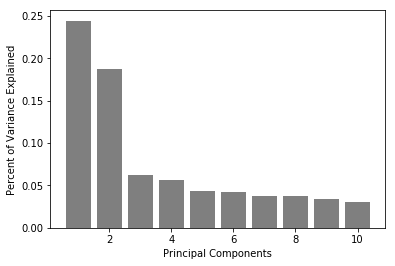

In [16]:
total_reduced = data_trans.copy().tolist()
# print(total_reduced)
# print(pca.components_)
n  = list(range(1,11))
var = pca.explained_variance_ratio_
print(len(var))
plt.xlabel('Principal Components')
plt.ylabel('Percent of Variance Explained')
plt.bar(n, var)
plt.show()

Figure shows that PC1 and PC2 combined explain 44% of the variance of the data and the variance decreases significantly after the first 2 PC. Therefore, PC1 and PC2 will give us a reasonably good understanding of the data, and adding more PC will result in minimal improvement. From the previous k-means clustering, we suspect that there might be only 4 clusters. Therefore, we start to conduct k-means clustering on dataset with 2 PC with 4 cluster centers.

### How K-means performance changes after PCA?

In [38]:
#gaussian  = GaussianMixture(n_components = 5).fit(data_trans)
pca = PCA(n_components = 2).fit(data)
kmeans = KMeans(n_clusters=4).fit(data_trans)
clusterNames = {}
clusterList = {}
labels = list(kmeans.labels_)
centers = kmeans.cluster_centers_.tolist()

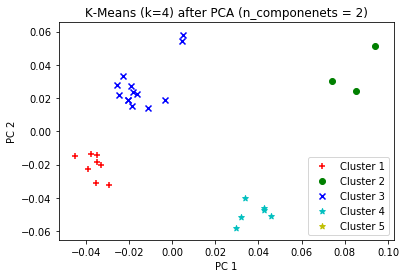

In [40]:
for i in range(0, data_trans.shape[0]):
	if kmeans.labels_[i] == 0:
		c1= pl.scatter(data_trans[i,0], data_trans[i,1], c='r', marker = '+')
	elif kmeans.labels_[i] == 1:
		c2= pl.scatter(data_trans[i,0], data_trans[i,1], c='g', marker = 'o')
	elif kmeans.labels_[i] == 2:
		c3= pl.scatter(data_trans[i,0], data_trans[i,1], c='b', marker = 'x')
	elif kmeans.labels_[i] == 3:
		c4= pl.scatter(data_trans[i,0], data_trans[i,1], c='c', marker = '*')
	elif kmeans.labels_[i] == 4:
		c5= pl.scatter(data[i,0], data[i,1], c='y', marker = '*')

pl.legend([c1, c2, c3, c4,c5], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4','Cluster 5' ])
pl.title('K-Means (k=4) after PCA (n_componenets = 2)')
pl.xlabel('PC 1')
pl.ylabel('PC 2')
pl.show()

This graph shows that 2 points belong to the cluster 4 “light blue” might belongs to different cluster. Therefore, we should try to run the data on k-means with k=5 to check whether a fifth cluster exists. This makes sense because previously, we already identify that the cluster 1 and cluster 5 are very similar.

![alt text](https://user-images.githubusercontent.com/30711638/35763094-5fe63b7e-0872-11e8-941c-2005a4c45a4b.png)

Figure 1 shows that unlike we thought, the new cluster is blending within cluster 4, not explicitly separating from cluster 2. These 2 bike shops (blue dots) aren’t belong to group 4, so we should modify the groups by switching these 2 bike shops from group 2 to group 4. After this adjustment, we conduct the k-means with k = 5 again. The result shown in figure 2 proves these clusters look good. By looking closely at the records in cluster 2 and cluster 4, we can see that customers in group 2 tend to buy low-end mountain bikes whereas group 4’s top purchases also prefer low-end bikes but with a mixture of Mountain and Road. This subtle difference makes these customers belong to 2 groups.

## 2.3) ICA and Random Projection
Figure 3 shows that the cluster positions constructed from k-means after ICA is slightly different from figure 2 (k-means after PCA). By inspecting the customer names belongs to each cluster, we find out that the customers in 5 groups clustered by k-means after both PCA and ICA are the same as shown in table 6 even though the arrangement of clusters might be different based on the scatterplot. This might be because our sample size only has 30 customers, so a small change in components used for clustering might not make much difference. However, this is not the case if we use components resulting by Random Projection. Figure 4 and figure 5 plot the results of k-means clustering after Gaussian and Sparse Random Projection. We can notice that these random components perform worse because the clusters are not as compact as those clusters constructed by PCA and ICA’s components. After running the random projection many times, the clusters relatively vary with different iterations with slight different numbers of customers belong to each clusters and cluster arrangement. However, the compactness of clustering are about the same. This variation might be because the distance between different clusters are not so far as we observe in figure 4 and 5, so only slight move, a customer can be clustered into different group. Also, table 7 records customers clustered by Gaussian Random Projection, and each cluster contains approximately 2 to 3 customers that are the same as PCA and ICA. Therefore, we can conclude that random projection give a less accurate, but rough estimate for our clusters. As we expected, ICA and PCA perform much better and more consistent for this dataset.
![alt text](https://user-images.githubusercontent.com/30711638/35763162-e058f142-0873-11e8-8a16-8bf2533aaa87.png)

### 2.4) Expectation Maximization

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


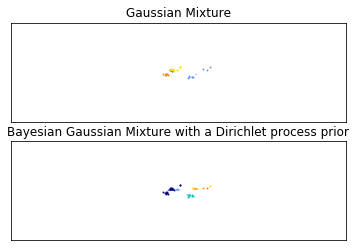

In [23]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
# C = np.array([[0., -0.1], [1.7, .4]])
# X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
#           .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]
X = data_trans
# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=5,
                                        covariance_type='full').fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

plt.show()

![alt text](https://user-images.githubusercontent.com/30711638/35763181-3ee8211a-0874-11e8-87a4-e85c9ed51864.png)
We can see that EM generally perform very well on our dataset and performance of 3 dimension reduction are very close, don’t show significant improvement one over another.
We can’t check the accuracy of Neural Network in this dataset because this is an unlabeled data, but the visualization can help us to evaluate our result

# Conclusion
In segmentation problem, dimensionality transformation such as PCA can be a valuable cross-check to k-means as we observe that k-means might not pick up the small differences between 2 groups and make the wrong prediction. As in our example, k-means got us close to the true customer segments, yet visually evaluating the groups using PCA helps identify a different customer segment which k-mean (k=5) did not pick up. Moreover, it’s not easy to visualize our clusters with so many dimensions. By reducing our dataset down and visualizing it in 2 or 3 dimensions, it can help us to check the performance of our algorithm and identify the outliners or abnormal points.  